# Airplane, Leopard, or Dolphin?

### Using the Visual Bag of Word Technique to determine the subject of a photo
#### By Sean Mills

  In this project I will be using a popular method in Computer Vision called **Bag of Visual Words** to try to correctly classify whether the subject of an image is of an airplane, leopard or dolphin. The orgins behind Visual Bag of Words  lie in the Bag of Words technique in Natural Language Processing (or NLP) where a document is scanned and every word is counted and the counts are placed in a histogram. This histogram of word frequencies can then be used to describe this document and derive context from it.   
  Similarly in Bag of Visual Words we extract visual features from an image and use histograms of common features to try to infer what the content of an image is.    
  In this project I will go over all parts of Bag of Visual Words using python with the [Numpy](https://numpy.org/doc/stable/) library for matrix operations, [Scikit-learn](https://scikit-learn.org/stable/) for KMeans and SVMs, [OpenCV](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_tutorials.html) for feature extraction and [Matplotlib](https://matplotlib.org/) for data visualization.

## Table of Contents

1. [Importing Data](#Importing-Images)
2. [Feature Extraction](#Feature-Extraction)
3. [Creating Image Histograms](#Creating-Image-Histograms)
4. [Learning Visual Vocabulary](#Learning-Visual-Vocabulary)
5. [Predicting Class & Results](#Predicting-Class-&-Results)


## Importing Images

In this section I will be importing all of the packages I need for this project as well as importing all of the images I will be using for classification.   
The images I used in this project come from the [Open Images](https://storage.googleapis.com/openimages/web/index.html) library which contains over 600 classes and 1.7 million images all maintained by Google. I also used the 
[OIDv4 Toolkit](https://github.com/EscVM/OIDv4_ToolKit) to help with downloading the needed images without bounding boxes.  
After importing the images and storing them in NumPy arrays I also plotted one image from each class, using OpenCV to mark features. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import cv2
import os

# Reads all images in given directory
def read_images(image_dir, N=None, resize_val=None):
    img_names = os.listdir(image_dir)
    M = len(img_names)
    imgs = list()
    if (N is not None):
        img_names = img_names[:N]
    
    for i, img_name in enumerate(img_names):
        img_file = os.path.join(image_dir, img_name)
        img = cv2.imread(img_file)
        if img is not None:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if (resize_val is not None):
                img_gray = cv2.resize(img_gray, (0, 0), fx=0.5, fy=0.5)
            imgs.append(img_gray)
        
    return imgs

airplanes = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Airplane')
dolphins = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Dolphin')
leopards = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Leopard')

In [2]:
def plot_img_and_keypoints(img):
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
    ax1.imshow(img, cmap='gray')
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    img_kp = cv2.drawKeypoints(img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax2.imshow(img_kp)

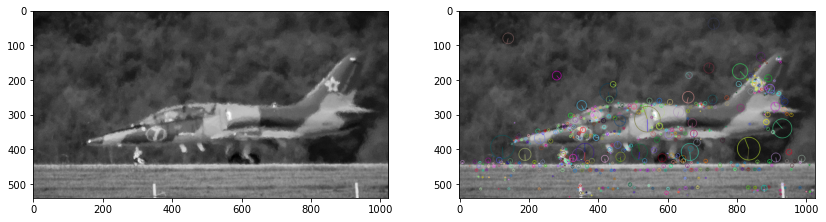

In [3]:
plot_img_and_keypoints(airplanes[4])

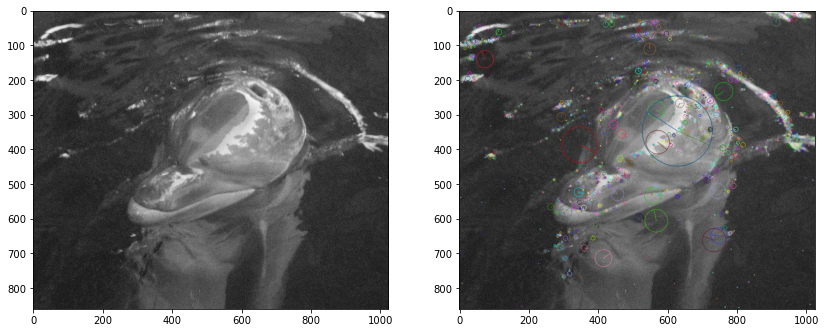

In [4]:
plot_img_and_keypoints(dolphins[0])

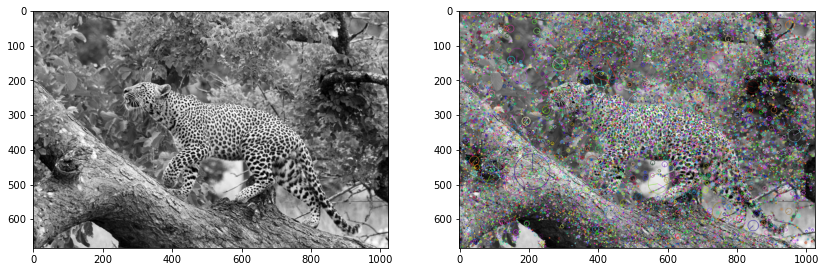

In [5]:
plot_img_and_keypoints(leopards[1])

## Feature Extraction

Now that I have imported the images I need for classification the next step will be to find the features of each image and the descriptors of each feature. To do this I will be using the SIFT algorithm, or Scale-Invariant Feature Transform, to find image key points and descriptors. SIFT is a common feature detection algorithm that is able to find the same key points, typically corners, even after an image has been rotated and scaled. This is the different from the Harris corner detection algorithm, that is rotation invariant but not scale invarient.     
There are four main steps to SIFT that I will go over below:

1. **Scale-space Extrema Detection**: In order to detect key points at different scales the image is convolved with a Gaussian filter to eliminate any noise in the image on a few selected scales (labelled as $\sigma$). After the Gaussian blurring we then calculate the difference of Gaussians (or DOG) between two different scales (let it be $\sigma$ and $k \centerdot \sigma$). Candidates for keypoints are then taken as the local minima/maxima along all neighors in scale in space (this includes all 8 points directly surrounding a point as well the 9 point in the scale above it and 9 points in the scale below it).
2. **Keypoint Localization**: After candidates have been selected Taylor series expandsion is used to find the exact subpixel location of the extrema and its intensity. If the intensity is less than the specified threshold (by default 0.03) then the keypoint is discarded. Next a 2x2 Hessian matrix is computed that described the principle curvature around the point. The eigenvalues in the x and y direction are then compared and if the ratio of the higher eignevalue to the other is over the threshold (by default 10) then the keypoint is on an edge and is discarded. This eliminated all low contrast and edge keypoints.
3. **Orientation Assignment**: Next we determine the orientation of each key point to help achieve rotation invariance. Calculate the gradient magnitude and direction in the neighborhood around the key point. Then create an orientation histogram with 36 bins where each bin represents 10 degrees of coverage. Each "peak" is wieghted by the magnitude and scale with any peak over 80% of the highest also considered for keypoint orientation.
4. **Keypoint Descriptor**: A 16x16 neighborhood around the keypoint is taken. It is then divided into 16 subblocks of 4x4 size. For each subblock and 8 bin orientation histogram is created. All 16 subblocks with 8 bin histograms per subblock flatten into one 128 dimensional vector that can uniquely describe the keypoint.

In [7]:
sift = cv2.SIFT_create()

def get_set_descriptors(image_set, sift, min_kps=100):
    image_set_filtered = []
    keypoints = []
    descips = []
    for img in image_set:
        kp, des = sift.detectAndCompute(img,None)
        if (len(kp) > min_kps):
            image_set_filtered.append(img)
            descips.append(des)
            keypoints.append(kp)
    
    return image_set_filtered, keypoints, descips
        
airplanes_imgs, airplanes_kp, airplanes_des = get_set_descriptors(airplanes, sift)
dolphins_imgs, dolphins_kp, dolphins_des = get_set_descriptors(dolphins, sift)
leopards_imgs, leopards_kp, leopards_des = get_set_descriptors(leopards, sift)

In [8]:
print(len(airplanes_imgs), len(dolphins_imgs), len(leopards_imgs))
print(min(map(len, airplanes_kp)), min(map(len, dolphins_kp)), min(map(len, leopards_kp)))

1744 858 694
101 108 124


In [9]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)[::-1]

def get_top_kp_desc(keypoints, descriptors, n):
    top_kp = []
    top_desc = []
    for keypoint, descriptor in zip(keypoints, descriptors):
        kp_sorted_idx = argsort([kp.response for kp in keypoint])
        top_kp_idx = kp_sorted_idx[:n]
        top_kp.append([keypoint[i] for i in top_kp_idx])
        top_desc.append(descriptor[top_kp_idx,:])
    return top_kp, top_desc

min_kp = 101
kpa, desca = get_top_kp_desc(airplanes_kp, airplanes_des, min_kp)
kpd, descd = get_top_kp_desc(dolphins_kp, dolphins_des, min_kp)
kpl, descl = get_top_kp_desc(leopards_kp, leopards_des, min_kp)

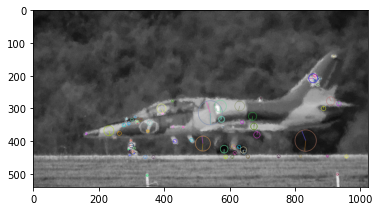

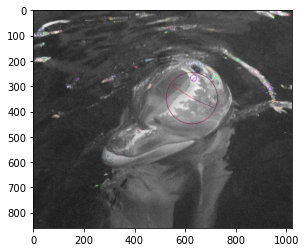

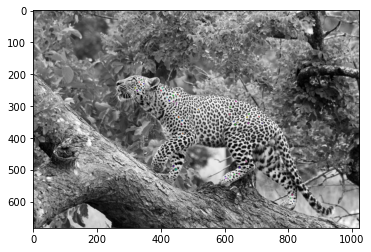

In [10]:
imga=cv2.drawKeypoints(airplanes[4],kpa[4],airplanes[4],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgd=cv2.drawKeypoints(dolphins[0], kpd[0],dolphins[0],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgl=cv2.drawKeypoints(leopards[1], kpl[1],leopards[1],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imga)
plt.show()
plt.imshow(imgd)
plt.show()
plt.imshow(imgl)

## Creating Image Histograms

Once descriptors have been generated for all the images in our dataet the next step of the Bag of Visual Words algorithm is to form clusters around similar features. For form the clusters I will use the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans) algorithm from Scikit-Learn.     
The KMeans algorithm works by starting off on k randomly chosen centroids then repeatably setting the new cluster centers to the center of all points closest to it. The process repeats until convergence, or until the maximum number of iterations has been reached.   
After many attempts I found $k = 400$ to be the optimal number of clusters.

In [12]:
train_size = 550
desca_train, desca_test, kpa_train, kpa_test, imga_train, imga_test = train_test_split(desca, kpa, airplanes_imgs, train_size=train_size)
descd_train, descd_test, kpd_train, kpd_test, imgd_train, imgd_test = train_test_split(descd, kpd, dolphins_imgs, train_size=train_size)
descl_train, descl_test, kpl_train, kpl_test, imgl_train, imgl_test  = train_test_split(descl, kpl, leopards_imgs, train_size=train_size)
print(len(desca_train), len(desca_test))
print(len(descd_train), len(descd_test))
print(len(descl_train), len(descl_test))

550 1194
550 308
550 144


In [13]:
desca_train_flat = np.vstack(desca_train)
descd_train_flat = np.vstack(descd_train)
descl_train_flat = np.vstack(descl_train)
desca_test_flat = np.vstack(desca_test)
descd_test_flat = np.vstack(descd_test)
descl_test_flat = np.vstack(descl_test)

In [14]:
train_set = np.concatenate((desca_train_flat, descd_train_flat, descl_train_flat))
train_keypoints = [kpa_train, kpd_train, kpl_train]
train_images = [imga_train, imgd_train, imgl_train]
test_set = np.concatenate((desca_test_flat, descd_test_flat, descl_test_flat))
test_keypoints = [kpa_test, kpd_test, kpl_test]
test_images = [imga_test, imgd_test, imgl_test]
# Print shape for check
print(train_set.shape)
print(test_set.shape)

(166650, 128)
(166246, 128)


In [33]:
k = 450
kmeans = KMeans(n_clusters=k)
train_labels = kmeans.fit_predict(train_set)

C:\Users\mills\anaconda3\envs\cmsc426\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [34]:
img_class_label = {'airplane': 0, 'dolphin': 1, 'leopard': 2}

def get_histograms_classes(labels, n, k, num_image_per_class, num_kp):
    histograms = np.zeros((n, k))
    class_labels = np.zeros(n, dtype=np.float64)
    labels_reshape = np.reshape(labels, (n, num_kp))
    j = 0

    for img_labels in labels_reshape:
        img_hist = np.bincount(img_labels, minlength=k)
        histograms[j,:] = img_hist
        j += 1

    if type(num_image_per_class) is tuple:
        airplane_size, dolphin_size, leopard_size = num_image_per_class
        class_labels[:airplane_size] = [img_class_label['airplane']] * airplane_size
        class_labels[airplane_size:(airplane_size + dolphin_size)] = [img_class_label['dolphin']] * dolphin_size
        class_labels[(airplane_size + dolphin_size):] = [img_class_label['leopard']] * leopard_size
    else:
        class_labels[:num_image_per_class] = [img_class_label['airplane']] * num_image_per_class
        class_labels[num_image_per_class:(2 * num_image_per_class)] = [img_class_label['dolphin']] * num_image_per_class
        class_labels[(2 * num_image_per_class):] = [img_class_label['leopard']] * num_image_per_class

    return histograms, class_labels


train_histograms, train_classes = get_histograms_classes(train_labels, 3 * train_size, k, train_size, min_kp)
    

In [35]:
# Given the cluster labels, name of image class, image number in class, number of images in class and number of keypoints in image
# Returns the cluster labels for all the keypoints in the image
def get_img_cluster_labels(labels, img_class, img_num, img_per_class, kp_per_img):
    img_class_num = img_class_label.get(img_class)
    if img_class_num is None or img_num > img_per_class:
        raise ValueError('Bad arguments')
    start_idx = img_class_num * img_per_class + img_num * kp_per_img
    end_idx = start_idx + kp_per_img
    return labels[start_idx:end_idx]

# Given the overall keypoint index, number of images per class and number of keypoints per image
# Returns the class number, image number within class, and keypoint number within the image
def get_class_imgnum_from_index(keypoint_index, img_per_class, kp_per_img):
    image_index = keypoint_index // kp_per_img
    class_num = image_index // img_per_class
    image_num = image_index - class_num * img_per_class
    kp_num = keypoint_index % kp_per_img
    if class_num > 2 or image_num < 0 or image_num > img_per_class:
        raise ValueError('Bad arguments; Class num or image num outside range')
    return class_num, image_num, kp_num


In [36]:
def get_img_histogram(histograms, img_class, img_num, img_per_class):
    img_class_num = img_class_label.get(img_class)
    if img_class_num is None or img_num > img_per_class:
        raise ValueError('Bad arguments')
    img_idx = img_class_num * img_per_class + img_num
    return histograms[img_idx]

<BarContainer object of 450 artists>

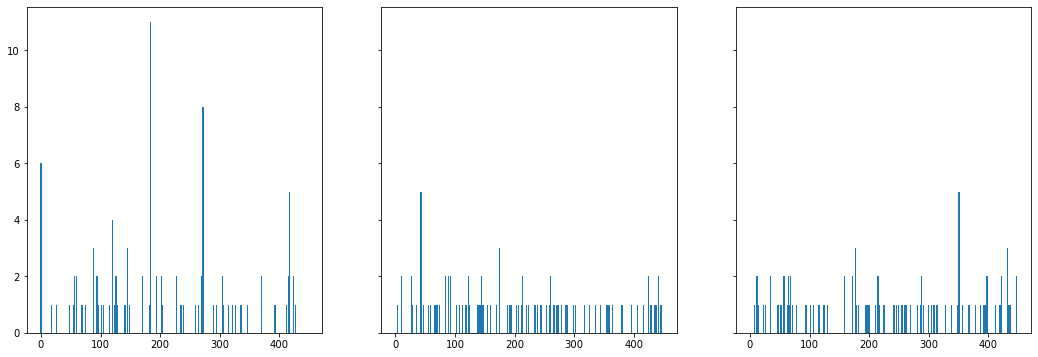

In [37]:
img1_hist = get_img_histogram(train_histograms, 'airplane', 4, train_size)
img2_hist = get_img_histogram(train_histograms, 'dolphin', 0, train_size)
img3_hist = get_img_histogram(train_histograms, 'leopard', 1, train_size)



fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
ax1.bar(range(k), img1_hist, width=2)
ax2.bar(range(k), img2_hist, width=2)
ax3.bar(range(k), img3_hist, width=2)

In [38]:
# Given the overall keypoint index, number of images per class and number of keypoints per image
# Returns the class number, image number within class, and keypoint number within the image
def get_class_imgnum_from_index(keypoint_index, img_per_class, kp_per_img):
    image_index = keypoint_index // kp_per_img
    class_num = image_index // img_per_class
    image_num = image_index - class_num * img_per_class
    kp_num = keypoint_index % kp_per_img
    if class_num > 2 or image_num < 0 or image_num > img_per_class:
        raise ValueError('Bad arguments; Class num or image num outside range')
    return class_num, image_num, kp_num

# Returns the image to the closest of each cluster centroid
def get_cluster_images(labels, centroids, descriptors, keypoints, images, patch_area=30):
    indices = np.arange(descriptors.shape[0])
    cluster_imgs = []
    for center_num, centroid in enumerate(centroids):
        # Get all descriptors within cluster
        kp_indices = np.nonzero(labels == center_num)
        cluster_descs = descriptors[kp_indices]

        # Find descriptor closest to the centroid point
        dists = np.linalg.norm(cluster_descs - centroid, axis=1)
        min_idx = np.argmin(dists)
        descriptor_index = indices[kp_indices][min_idx]

        # Find the class, image, and keypoints that this descriptor came from
        i_class, i_image, i_kp = get_class_imgnum_from_index(descriptor_index, train_size, min_kp)
        image = images[i_class][i_image]
        keypoint = keypoints[i_class][i_image][i_kp]
        
        # Take a small snippet from the keypoint images around the keypoint location
        x, y = keypoint.pt
        image_padded = np.pad(image, patch_area, mode='constant')
        x, y = x + patch_area, y + patch_area
        patch = image_padded[round(y-patch_area):round(y+patch_area),round(x-patch_area):round(x+patch_area)]
        cluster_imgs.append(patch)

    return np.asarray(cluster_imgs)

cluster_images = get_cluster_images(train_labels, kmeans.cluster_centers_, train_set, train_keypoints, train_images)


C:\Users\mills\anaconda3\envs\cmsc426\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


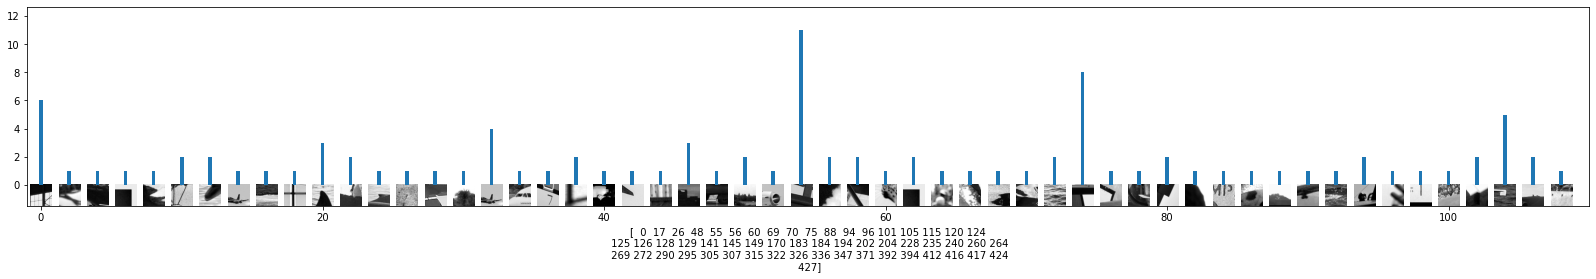

In [39]:
def plot_vocabulary(images, histogram):
    # Get all visual words present in the image
    cluster_nums = np.nonzero(histogram)[0]
    counts = histogram[cluster_nums]
    plt.figure(figsize=(28, 18))
    plt.bar(range(0, 2 * len(cluster_nums), 2), counts, width=0.25)
    for i, cluster_num in enumerate(cluster_nums):
        plt.imshow(images[cluster_num], cmap='gray', extent = (-.75 + 2*i, .75 + 2*i, -1.5, .0))
    plt.xlim(-1, 2 * len(cluster_nums))
    plt.ylim(-1.5, max(counts) * 1.15)
    plt.xlabel(cluster_nums)
    plt.show()
    
plot_vocabulary(cluster_images, img1_hist)

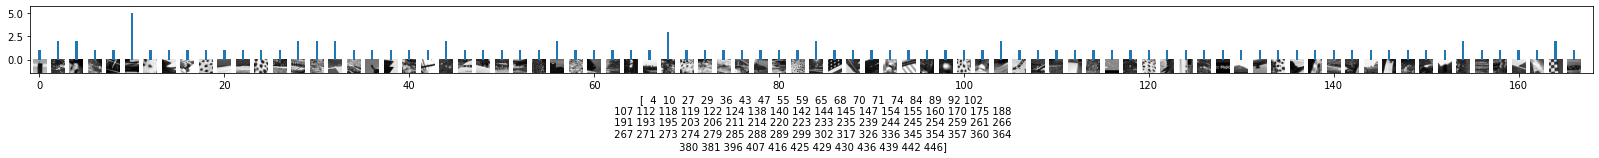

In [40]:
plot_vocabulary(cluster_images, img2_hist)

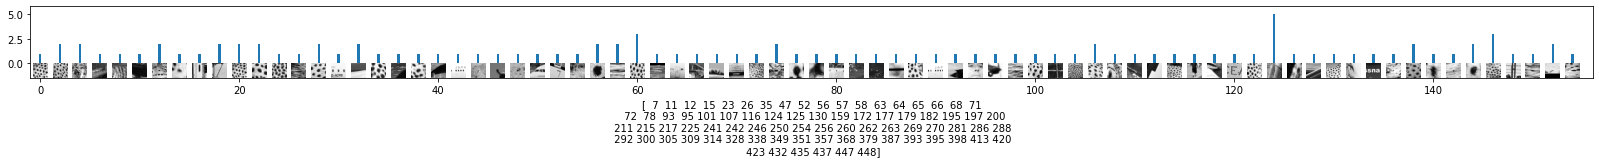

In [41]:
plot_vocabulary(cluster_images,img3_hist)

In [38]:
def plot_vocabulary_keypoints(cluster_images, labels, images, keypoints, class_name, img_num, patch_area=30):
    class_num = img_class_label[class_name]
    img = images[class_num][img_num]
    img_keypoints = keypoints[class_num][img_num]
    img_labels = get_img_cluster_labels(labels, class_name, img_num, train_size, min_kp)
    img_padded = np.pad(img, patch_area, mode='constant')
    for i, (label, keypoint) in enumerate(zip(img_labels, img_keypoints)):
        cluster_img = cluster_images[label]
        x, y = keypoint.pt
        x, y = x + patch_area, y + patch_area
        patch = img_padded[round(y-patch_area):round(y+patch_area),round(x-patch_area):round(x+patch_area)]
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(4, 4))
        ax1.imshow(cluster_img, cmap='gray')
        ax2.imshow(patch, cmap='gray')
    plt.show()

# plot_vocabulary_keypoints(cluster_images, train_labels, train_images, train_keypoints, 'airplane', 4)

### Term Frequentcy - Inverse Document Frequency weighting

In [64]:
def get_tf_idf_weights(histograms):
    num_docs = histograms.shape[0]
    idf = np.log(num_docs / np.count_nonzero(train_histograms, axis=0))
    weighted = histograms * idf
    return weighted

train_histograms_weighted = get_tf_idf_weights(train_histograms)

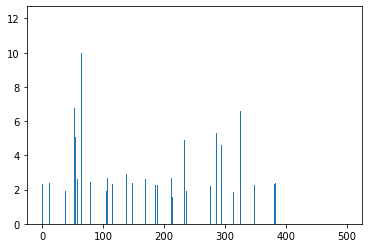

In [65]:
img1_hist = get_img_histogram(train_histograms_weighted, 'airplane', 4, train_size)
plt.bar(range(k), img1_hist)
plt.show()

## Learning Visual Vocabulary

Now that we have grouped similar features into clusters and formed a unique histogram for each image it is time to learn the visual vocabulary for all images. To do this I will use a Support Vector Machine (or SVM) to learn which features are more common to each class.   
The SVM I will be using comes from scikit learn's [C-Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with the one-vs-one scheme. Under the one-vs-one scheme for multi-class classification each image class (airplane, dolphin, or leopard) is compared against one other class. Once the SVM is trained we can use it to predict an unknown images class based on its image histogram.

In [42]:
shuffle_idx = np.arange(len(train_histograms))
np.random.shuffle(shuffle_idx)
train_histograms = train_histograms[shuffle_idx]
train_classes = train_classes[shuffle_idx]

In [43]:
train_classes

array([2., 0., 0., ..., 2., 2., 2.])

In [44]:
classifier = svm.SVC(kernel='linear', decision_function_shape='ovo')
classifier.fit(train_histograms, train_classes)
print(classifier)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [45]:
train_predicts = classifier.predict(train_histograms)
train_cm = confusion_matrix(train_classes, train_predicts)
print("confusion matrix")
print("airplane, dolphin, leopard")
print(train_cm)
print("Accuracy: ", (train_cm[0,0] + train_cm[1,1] + train_cm[2,2]) / np.sum(train_cm))

confusion matrix
airplane, dolphin, leopard
[[545   5   0]
 [  3 547   0]
 [  0   0 550]]
Accuracy:  0.9951515151515151


## Predicting Class & Results

Finally, now that the SVM has been fully trained we can plug the test image histograms into the SVM and try to predict their image classes. After the predictions have been created we can then compare our predictions to the true classes to arrive an our total accuracy. I will also use a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion%20matrix#sklearn.metrics.confusion_matrix) to compare the predicted and actual classes on a class by class basis.

In [29]:
test_img_sizes = (len(desca_test), len(descd_test), len(descl_test))
test_labels = kmeans.predict(test_set)

In [30]:
test_histograms, test_classes = get_histograms_classes(test_labels, sum(test_img_sizes), k, test_img_sizes, min_kp)
# test_histograms_weighted = get_tf_idf_weights(test_histograms)
predictions = classifier.predict(test_histograms)

In [31]:
print(predictions.shape)
print(test_classes.shape)
print([len(desca_test), len(descd_test), len(descl_test)])

(1646,)
(1646,)
[1194, 308, 144]


In [46]:
test_cm = confusion_matrix(test_classes, predictions)

print("confusion matrix")
print("airplane, dolphin, leopard")
print(test_cm)
print("accuracy: ", (test_cm[0,0] + test_cm[1,1] + test_cm[2,2]) / np.sum(test_cm))

confusion matrix
airplane, dolphin, leopard
[[774 352  68]
 [ 94 187  27]
 [ 18  12 114]]
accuracy:  0.6530984204131227
